# Gold standard Example 1

In [8]:
TRAIT = 'Breast Cancer'
CONDITION = 'age'
QUESTION = f'What are the genetic factors related to {TRAIT} when considering the influence of {CONDITION}?'
print(f"Studied question: {QUESTION}")

Studied question: What are the genetic factors related to Breast Cancer when considering the influence of age?


In [2]:
"""# This cell is only for use on Google Colab. Skip it if you run your code in other environments

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_root = '/content/drive/MyDrive/AI4Science_Public/data'
os.chdir(data_root)
!ls"""

"# This cell is only for use on Google Colab. Skip it if you run your code in other environments\n\nimport os\nfrom google.colab import drive\ndrive.mount('/content/drive', force_remount=True)\ndata_root = '/content/drive/MyDrive/AI4Science_Public/data'\nos.chdir(data_root)\n!ls"

### Select the data files
Set the paths to relevant data directories and files
We know that in TCGA Xena, the gene expression data are stored in the PANCAN files, while the trait and condition information are stored in the clinicalMatrix files. In a clinicalMatrix file, the condition information is recorded in one of its columns, and the trait information can be obtained from sample IDs.

In [3]:
import os

data_root = './data'
dataset = 'TCGA'
trait_subdir = "TCGA_Breast_Cancer_(BRCA)"
clinical_data_file = os.path.join(data_root, dataset, trait_subdir, 'TCGA.BRCA.sampleMap_BRCA_clinicalMatrix')
genetic_data_file = os.path.join(data_root, dataset, trait_subdir, 'TCGA.BRCA.sampleMap_HiSeqV2_PANCAN.gz')

### 1. Data Preprocessing

In [4]:
import pandas as pd

clinical_data = pd.read_csv(clinical_data_file, sep='\t', index_col=0)
genetic_data = pd.read_csv(genetic_data_file, compression='gzip', sep='\t', index_col=0)

In [5]:
def check_rows_and_columns(dataframe):
    dataframe_rows = dataframe.index.tolist()
    print(f"The dataset has {len(dataframe_rows)} rows, such as {dataframe_rows[:20]}")
    dataframe_cols = dataframe.columns.tolist()
    print(f"\nThe dataset has {len(dataframe_cols)} columns, such as {dataframe_cols[:20]}")
    return dataframe_rows, dataframe_cols

In [6]:
clinical_data_rows, clinical_data_cols = check_rows_and_columns(clinical_data)

The dataset has 1247 rows, such as ['TCGA-3C-AAAU-01', 'TCGA-3C-AALI-01', 'TCGA-3C-AALJ-01', 'TCGA-3C-AALK-01', 'TCGA-4H-AAAK-01', 'TCGA-5L-AAT0-01', 'TCGA-5L-AAT1-01', 'TCGA-5T-A9QA-01', 'TCGA-A1-A0SB-01', 'TCGA-A1-A0SD-01', 'TCGA-A1-A0SE-01', 'TCGA-A1-A0SF-01', 'TCGA-A1-A0SG-01', 'TCGA-A1-A0SH-01', 'TCGA-A1-A0SI-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SK-01', 'TCGA-A1-A0SM-01', 'TCGA-A1-A0SN-01', 'TCGA-A1-A0SO-01']

The dataset has 193 columns, such as ['AJCC_Stage_nature2012', 'Age_at_Initial_Pathologic_Diagnosis_nature2012', 'CN_Clusters_nature2012', 'Converted_Stage_nature2012', 'Days_to_Date_of_Last_Contact_nature2012', 'Days_to_date_of_Death_nature2012', 'ER_Status_nature2012', 'Gender_nature2012', 'HER2_Final_Status_nature2012', 'Integrated_Clusters_no_exp__nature2012', 'Integrated_Clusters_unsup_exp__nature2012', 'Integrated_Clusters_with_PAM50__nature2012', 'Metastasis_Coded_nature2012', 'Metastasis_nature2012', 'Node_Coded_nature2012', 'Node_nature2012', 'OS_Time_nature2012', 'OS

In [7]:
genetic_data_rows, genetic_data_cols = check_rows_and_columns(genetic_data)

The dataset has 20530 rows, such as ['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1', 'REM1', 'MTVR2', 'RTN4RL2', 'C16orf13', 'C16orf11', 'FGFR1OP2', 'TSKS', 'ATRX', 'PMM2', 'LOC100272146', 'ASS1', 'NCBP1', 'ZNF709']

The dataset has 1218 columns, such as ['TCGA-AR-A5QQ-01', 'TCGA-D8-A1JA-01', 'TCGA-BH-A0BQ-01', 'TCGA-BH-A0BT-01', 'TCGA-A8-A06X-01', 'TCGA-A8-A096-01', 'TCGA-BH-A0C7-01', 'TCGA-AC-A5XU-01', 'TCGA-PE-A5DE-01', 'TCGA-PE-A5DC-01', 'TCGA-AR-A0TV-01', 'TCGA-GM-A3XG-01', 'TCGA-BH-A18J-01', 'TCGA-BH-A0W7-01', 'TCGA-E9-A3QA-01', 'TCGA-A7-A4SD-01', 'TCGA-BH-A0HA-01', 'TCGA-AR-A5QN-01', 'TCGA-A7-A0CH-11', 'TCGA-A7-A0CE-01']


In [8]:
gene_list = genetic_data_rows
genetic_data = genetic_data.T

Read all the features names of the clinical dataset, 'clinical_data_cols' in this case, and select the variable recording information about the condition.

In [9]:
CONDITION_COL = 'days_to_birth'

The target variable about the trait is binary, meaning "whether the sample shows the trait", and we need to decode it from sample IDs.

In [10]:
# Only select the column of condition feature in the clinical data
clinical_data = clinical_data[[CONDITION_COL]]
# Merge clinical_data and gene_data on their indices - sample_ID, corresponding to each person
merged_data = clinical_data.join(genetic_data).dropna()

In [11]:
# Decode the trait information from Sample IDs depending on the last two digits.
# Tumor types range from 01 - 09, normal types from 10 - 19.

def mark_label(row_index):
    last_two_digits = int(row_index[-2:])

    if 1 <= last_two_digits <= 9:
        return 1
    elif 10 <= last_two_digits <= 19:
        return 0
    else:
        return -1

# Use the apply function to add the trait column to merged_data
merged_data[TRAIT] = merged_data.index.to_series().apply(mark_label)
merged_data = merged_data.loc[merged_data[TRAIT] >= 0]

In [12]:
def judge_binary_variable_biased(dataframe, col_name, min_proportion, min_num):
    label_counter = dataframe[col_name].value_counts()
    total_samples = len(dataframe)
    rare_label_num = label_counter.min()
    rare_label = label_counter.idxmin()
    rare_label_proportion = rare_label_num / total_samples

    print(f"The least common label is '{rare_label}' with {rare_label_num} occurrences. This represents {rare_label_proportion:.2%} of the dataset.")

    biased = (len(label_counter) < 2) or ((rare_label_proportion < min_proportion) and (rare_label_num < min_num))
    return biased

In [13]:
def judge_continuous_variable_biased(dataframe, col_name):
    # Calculate the quartiles of the continuous variable
    quartiles = dataframe[col_name].quantile([0.25, 0.5, 0.75])
    min_value = dataframe[col_name].min()
    max_value = dataframe[col_name].max()

    # Printing quartile information
    print(f"Quartiles for '{col_name}':")
    print(f"  25%: {quartiles[0.25]}")
    print(f"  50% (Median): {quartiles[0.5]}")
    print(f"  75%: {quartiles[0.75]}")
    print(f"Min: {min_value}")
    print(f"Max: {max_value}")

    # Check if the variable is too biased for regression analysis.
    # As a starting point, we consider it biased if all values are the same
    # For the next step, maybe ask GPT to judge based on the quartile statistics combined with its common sense knowledge about this feature.
    biased = min_value == max_value

    return biased

In [14]:
print(f"The merged dataset contains {len(merged_data)} samples.")

The merged dataset contains 1199 samples.


In [15]:
biased = judge_binary_variable_biased(merged_data, TRAIT, 0.1, 10)
if biased:
    print(f"The distribution of the trait \'{TRAIT}\' in this dataset is severely biased.")
else:
    print(f"The distribution of the trait \'{TRAIT}\' in this dataset is fine.")

The least common label is '0' with 112 occurrences. This represents 9.34% of the dataset.
The distribution of the trait 'Breast Cancer' in this dataset is fine.


In [16]:
biased = judge_continuous_variable_biased(merged_data, CONDITION_COL)
if biased:
    print(f"The distribution of the condition \'{CONDITION}\' in this dataset is severely biased.")
else:
    print(f"The distribution of the condition \'{CONDITION}\' in this dataset is fine.")

Quartiles for 'days_to_birth':
  25%: -24819.5
  50% (Median): -21488.0
  75%: -17793.0
Min: -32873.0
Max: -9706.0
The distribution of the condition 'age' in this dataset is fine.


### 2. Preliminary analysis

Plot the distributions of the target and important regressors

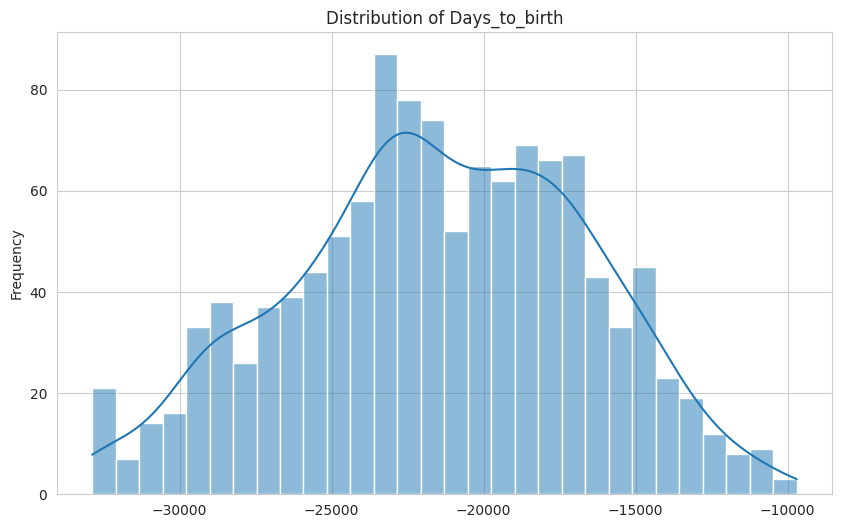

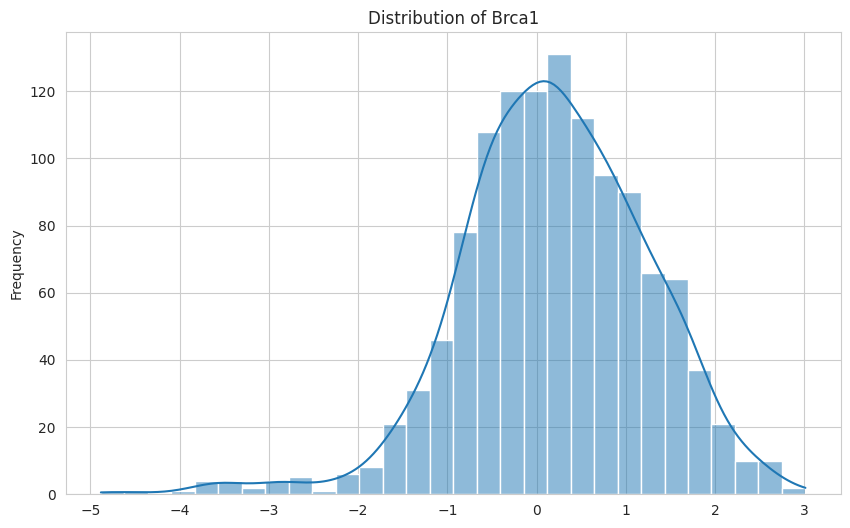

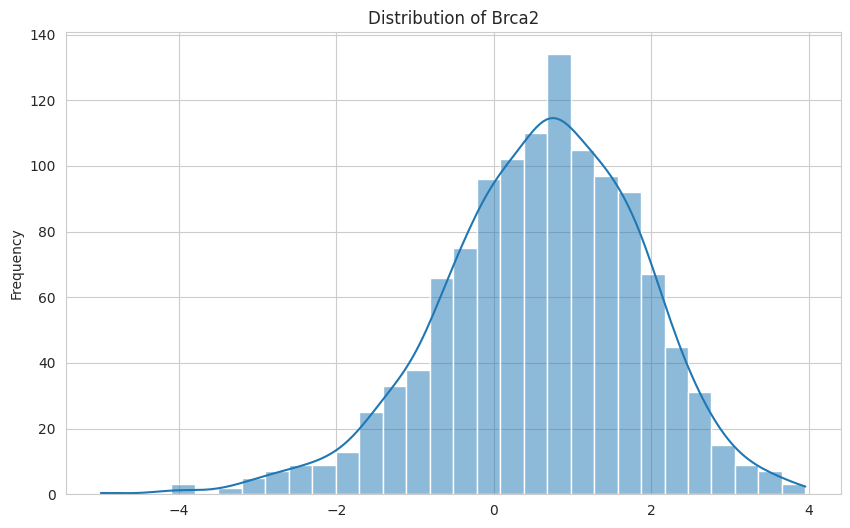

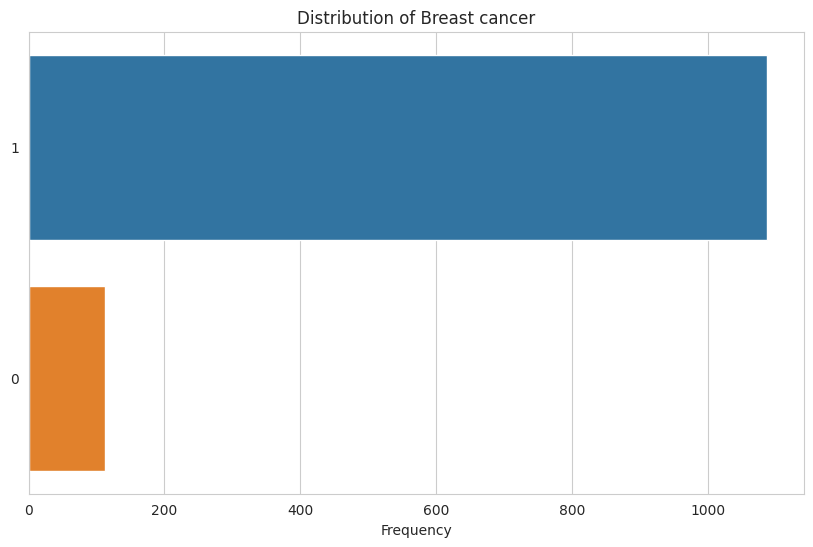

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('')
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical_distribution(df, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=df, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column.capitalize()}')
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

def analyze_distributions(df, numerical_columns, categorical_columns):
    for col in numerical_columns:
        plot_numeric_distribution(df, col)

    for col in categorical_columns:
        plot_categorical_distribution(df, col)

# For example, we may want to choose a few genes we are interested in for visualization:
interested_genes = [col for col in gene_list if 'brca' in col.lower()]
analyze_distributions(merged_data, numerical_columns=[CONDITION_COL, *interested_genes], categorical_columns=[TRAIT])

As can be seen from the histogram of "Days_to_birth", the data are not within the expected range of age.
This is also indicated by the variable name.

Then, draw scatter plots to visualize the relationship between pairs of variables (Optional)

In [10]:
# Convert "day_to_birth" to age in years
merged_data[CONDITION_COL] = (- merged_data[CONDITION_COL] / 365.25).astype(int)
feature_cols = merged_data.columns.tolist()[:-1]

merged_data.head()

,sampleID,days_to_birth,ARHGEF10L,HIF3A,RNF17,RNF10,RNF11,RNF13,GTF2IP1,REM1,...,NPY5R,GNGT2,GNGT1,TULP3,PTRF,BCL6B,GSTK1,SELP,SELS,Tumor
0,TCGA-3C-AAAU-01,0,0.607308,-3.194126,-0.531035,-0.145872,0.237422,-0.29921,-0.142694,-0.217446,...,0.565583,-0.767233,-1.28139,-0.271377,-0.492286,0.360373,1.067905,0.076267,-0.392212,1
1,TCGA-3C-AALI-01,0,-0.641192,-4.928226,0.095465,0.098128,-0.541978,-0.32291,-0.044694,-0.148846,...,0.079683,0.475267,1.99661,0.161423,0.273714,0.644673,-0.428695,0.068667,-0.043812,1
2,TCGA-3C-AALJ-01,0,1.082808,-4.623726,-0.531035,0.484028,-0.183678,-0.91901,0.261106,0.687754,...,-0.656117,-0.216733,0.21081,0.101023,0.660514,1.295073,0.915105,0.168567,0.047788,1
3,TCGA-3C-AALK-01,0,0.121608,-2.881526,-0.531035,0.179128,0.039222,-0.45491,0.180306,0.775554,...,-0.178417,-0.211233,-1.28139,0.108023,1.132814,0.496773,0.240105,3.099767,0.112888,1
4,TCGA-4H-AAAK-01,0,0.420208,-3.282726,-0.531035,-0.020972,-0.117978,-0.55781,-0.173794,-1.079146,...,-0.698717,-0.484233,-1.28139,-0.223577,1.222714,0.225573,-0.301995,0.200067,-0.080212,1


In [11]:
# Diagnose the batch effect
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Step 1: find a potential factors
merged_data['TSS'] = merged_data.index.to_series().apply(lambda x: x.split('-')[1])

expression_data = merged_data.drop([TRAIT, 'TSS'], axis=1)

# Step 2: Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expression_data)

# Add PCA results to the DataFrame
merged_data['pca_one'] = pca_result[:,0]
merged_data['pca_two'] = pca_result[:,1]

# Visualize PCA results
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='pca_one', y='pca_two',
    hue='TSS',
    palette=sns.color_palette("hsv", len(merged_data['TSS'].unique())),
    data=merged_data,
    legend="full",
    alpha=0.7
)
plt.title('PCA by TSS')
plt.show()

# Step 3: Use ANOVA to check for batch effects
# For ANOVA, we will use the first principal component 'pca_one'
model = ols('pca_one ~ C(TSS)', data=merged_data).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

significance_level = 0.05
batch_effect = int(anova_results['PR(>F)'][0] < significance_level)

# Display the ANOVA results
print(anova_results)

AttributeError: 'int' object has no attribute 'split'

Based on the PCA scatter plot and the results from the ANOVA test you've provided, here's the analysis:

1. PCA Scatter Plot Analysis:
The plot shows the distribution of samples from different TSS (tissue source sites) across the first two principal components.
The dispersion of points does not form completely separate clusters; however, we can observe that points of certain colors (representing specific TSS) tend to group together.
This suggests that there is some variation between different TSS, which could be indicative of batch effects.
ANOVA Test Results Analysis:

2. The purpose of the ANOVA test is to check for significant differences in gene expression between different TSS groups.
The F-statistic is 10.564247, indicating that the variance between groups is significant compared to the variance within groups.
The p-value (PR(>F)) is extremely small (5.053513e-32), far below common significance levels (such as 0.01 or 0.05), which strongly suggests significant differences between the TSS groups.

Conclusion:
Combining these two sets of results, we can conclude that there is a batch effect present in your dataset.

### 3. Do regression & Cross Validation

In [20]:
import numpy as np
from sparse_lmm import VariableSelection

def normalize_data(X_train, X_test=None):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    # Handling columns with std = 0
    std_no_zero = np.where(std == 0, 1, std)

    # Normalize X_train
    X_train_normalized = (X_train - mean) / std_no_zero
    # Set normalized values to 0 where std was 0
    X_train_normalized[:, std == 0] = 0

    if X_test is not None:
        X_test_normalized = (X_test - mean) / std_no_zero
        X_test_normalized[:, std == 0] = 0
    else:
        X_test_normalized = None

    return X_train_normalized, X_test_normalized



In [21]:
def cross_validation(X, y, k=5):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    fold_size = len(X) // k
    accuracies = []

    for i in range(k):
        # Split data into train and test based on the current fold
        test_indices = indices[i*fold_size : (i+1)*fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        # Preprocess the train and test data
        X_train, X_test = normalize_data(X_train, X_test)

        # Use the precision_lasso package for regression
        var_select = VariableSelection()
        var_select.fit(X_train, y_train)
        predictions = var_select.predict(X_test)

        # Turn the predictions into binary values using a threshold of 0.5
        binary_predictions = (predictions > 0.5).astype(int)

        # Calculate accuracy for this fold
        accuracy = np.mean(binary_predictions == y_test)
        accuracies.append(accuracy)

    return np.mean(accuracies), np.std(accuracies)

In [22]:
# Select relevant columns and convert to numpy array
y = merged_data[TRAIT].values
X = merged_data.drop(columns=[TRAIT]).values

cv_mean, cv_std = cross_validation(X, y)
print(f'The cross-validation accuracy is {(cv_mean * 100):.2f}% ± {(cv_std * 100):.2f}%')

/home/techt/anaconda3/envs/hl/lib/python3.8/site-packages/sparse_lmm/helpingMethods.py:49: RuntimeWarning: invalid value encountered in divide
  ts = beta / np.sqrt(var * sigma)
/home/techt/anaconda3/envs/hl/lib/python3.8/site-packages/sparse_lmm/VariableSelection.py:183: RuntimeWarning: divide by zero encountered in log
  return -np.log(p), np.array(betas)


The cross-validation accuracy is 88.98% ± 0.68%


In [2]:
import numpy as np
from sklearn.linear_model import LassoCV
from sparse_lmm import VariableSelection

# Conduct regression on the whole dataset
y = merged_data[TRAIT].values
X = merged_data.drop(columns=[TRAIT]).values

X, _ = normalize_data(X)

if batch_effect == 1:
    # If there is batch effect, perform lmm for variable selection
    # Fit the model
    var_select = VariableSelection()
    var_select.fit(X, y)
    
    # Retrieve the coefficients
    coefficients = var_select.getBeta().reshape(-1).tolist()
    nlog_p_values = var_select.getNegLogP().reshape(-1).tolist()
    p_values = [np.exp(-p) for p in nlog_p_values]
else:
    # If there is no batch effect, perform Lasso regression for variable selection
    # Initialize LassoCV to perform Lasso regression with cross-validation
    lasso = LassoCV(cv=5, random_state=0) #LassoCV: automatically select the best lambda
    # Fit the Lasso model
    lasso.fit(X, y)
    # Retrieve the coefficients
    lassocoefficients = lasso.coef_

NameError: name 'VariableSelection' is not defined

### 4. Discussion

In [24]:
from statsmodels.stats.multitest import multipletests

if batch_effect == 1:
    # Create a DataFrame for the regression results
    regression_df = pd.DataFrame({
        'Variable': feature_cols,
        'Coefficient': coefficients,
        'p_value': p_values
    })

    # Extract information about the condition's effect
    condition_effect = regression_df.iloc[0]

    # Report the effect of the condition
    print(f"Effect of the condition on the target variable:")
    print(f"Variable: {CONDITION}")
    print(f"Coefficient: {condition_effect['Coefficient']:.4f}")
    print(f"p-value: {condition_effect['p_value']:.4g}\n")
else:
    # Report the significant variables
    print(f"Effect of the condition on the target variable:")
    print(f"Variable: {CONDITION}")
    print(f"Coefficient: {condition_effect['Coefficient']:.4f}")

Effect of the condition on the target variable:
Variable: age
Coefficient: -0.0028
p-value: 0.5624



In [3]:
threshold = 0.05
if batch_effect == 1:
    regression_df = pd.DataFrame({
        'Variable': feature_cols,
        'Coefficient': coefficients,
        'p_value': p_values
    })

    # Apply the Benjamini-Hochberg correction to get the corrected p-values
    corrected_p_values = multipletests(p_values, alpha=threshold, method='fdr_bh')[1]
    regression_df['corrected_p_value'] = corrected_p_values

    # Filter for significant genes
    significant_genes = regression_df.loc[regression_df['corrected_p_value'] < threshold]
    significant_genes_sorted = significant_genes.sort_values('corrected_p_value')

    # Print out the number of significant genes
    print(f"Found {len(significant_genes_sorted)} significant genes affecting the trait '{TRAIT}' conditional on the factor '{CONDITION}', with corrected p-value < {threshold}:")
    print(significant_genes_sorted[['Variable', 'Coefficient', 'corrected_p_value']].to_string(index=False))

    # Save to a CSV file
    output_path = f'./output/{TRAIT}_{CONDITION}_significant_genes.csv'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    significant_genes_sorted.to_csv(output_path, index=False)
    
else: 
    # Filter for significant features
    significant_features = [feature for coef, feature in zip(lasso_coefficients, feature_cols) if coef > 0]
    significant_variables_df = pd.DataFrame({
        'Variable': significant_features,
        'Coefficient': [coef for coef in lasso_coefficients if coef > 0]
    })

    # Print out the significant variables
    print(f"Significant variables affecting the trait '{TRAIT}'")
    print(significant_variables_df.to_string(index=False))

    # Save to a CSV file
    output_path = f'./output/{TRAIT}_significant_genes.csv'
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    significant_variables_df.to_csv(output_path, index=False)

NameError: name 'batch_effect' is not defined